In [19]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pyspedas
from geopack import geopack
from pytplot import tplot
from pytplot import get_data
import pandas as pd
import pickle
from sklearn.decomposition import PCA
from esn_dts_openloop import ESN, Tikhonov
import datetime

ut_time = '1400'

def ut_to_idx(ut_time):
    ut_time = ut_time.replace(':', '')
    hour, minute = int(ut_time[:2]), int(ut_time[2:])
    minutes_since_midnight = hour * 60 + minute

    return 0 if minutes_since_midnight == 0 else minutes_since_midnight // 5 

idx = ut_to_idx(ut_time)
print(idx)

trange = ['2023-10-30', '2023-10-31']
omni_vars = pyspedas.omni.data(trange=trange,datatype='5min')
date_str = trange[0].replace('-', '') 

byo=get_data( 'BY_GSM')
bzo=get_data( 'BZ_GSM')
vvo=get_data( 'flow_speed')
nno=get_data( 'proton_density')
alo=get_data( 'AL_INDEX')
auo=get_data( 'AU_INDEX')
alp=pd.DataFrame(alo.y)
aup=pd.DataFrame(auo.y)

tto=byo.times
tlt2=np.zeros(tto.shape[0])

for ii in range(0,tto.shape[0]):
    ut = tto[ii]
    ps = geopack.recalc(ut)
    tlt2[ii]=ps

byp=pd.DataFrame(byo.y)
byp2 = byp.ffill()  # forward-fill missing BY values

bzp=pd.DataFrame(bzo.y)
bzp2 = bzp.ffill()  # forward-fill missing BZ values

vvp=pd.DataFrame(vvo.y)
vvp2 = vvp.ffill()  # forward-fill Vsw values

vvp2=np.log10(vvp2)-2.5

nnp=pd.DataFrame(nno.y)
nnp2 = nnp.ffill()  # forward-fill density values

nnp2=np.log10(nnp2)-1.0


09-Jan-26 10:26:23: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hro_5min/2023/


168


09-Jan-26 10:26:24: File is current: omni_data/hro_5min/2023/omni_hro_5min_20231001_v01.cdf
09-Jan-26 10:26:24: Floating point data values for variable PR-FLX_10 are all fillval (9.999999e+04)
09-Jan-26 10:26:24: Floating point data values for variable PR-FLX_30 are all fillval (9.999999e+04)
09-Jan-26 10:26:24: Floating point data values for variable PR-FLX_60 are all fillval (9.999999e+04)


# Compare all potential from SMRAI2/SMRAI2.1/SMRAI2.1_DAssim

In [20]:
# Create 1×3 subplots: SMRAI2 (ESN) potential, SMRAI2.1(cntrl), and SMRAI2.1 (DA-assim) potential

import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

all10 = np.vstack((tlt2.T,byp2.T,bzp2.T,vvp2.T,nnp2.T))
data_s = all10.T

flearn=1e-6 
with open('SMRAI2/modelp099_250.sav', 'rb') as f:
    modelp = pickle.load(f)
test_Y = modelp.predict(data_s)

meanp=np.load('SMRAI2/meanp.npy')
imgpcap=np.load('SMRAI2/imgp.npy')
datpcap=np.load('SMRAI2/pcap.npy')

nlat, nlon = 20, 72
theta = np.array([  1.688 ,   6.188 ,  10.688 ,  15.188 ,  19.688 ,  24.188 ,  28.688 ,
                    33.188 ,  37.688 ,  42.188 ,  46.688 ,  51.188 ,  55.688 ,  60.188 ,
                    64.688 ,  69.188 ,  73.688 ,  78.188 ,  82.688 ,  87.188 ,  91.688 ,
                    96.188 , 100.688 , 105.188 , 109.688 , 114.188 , 118.688 , 123.188 ,
                   127.688 , 132.188 , 136.688 , 141.188 , 145.687 , 150.188 , 154.688 ,
                   159.188 , 163.688 , 168.187 , 172.687 , 177.187 , 181.687 , 186.187 ,
                   190.687 , 195.187 , 199.687 , 204.187 , 208.687 , 213.187 , 217.687 ,
                   222.187 , 226.687 , 231.187 , 235.687 , 240.187 , 244.687 , 249.187 ,
                   253.687 , 258.187 , 262.687 , 267.187 , 271.687 , 276.187 , 280.687 ,
                   285.187 , 289.687 , 294.187 , 298.687 , 303.187 , 307.687 , 312.187 ,
                   316.687 , 321.187 , 325.687 , 330.187 , 334.687 , 339.187 , 343.687 ,
                   348.187 , 352.687 , 357.187 , 367.688]) - 90.0
theta = theta / 360 * 2 * np.pi

r = 90 - np.array([53.109 , 55.172 , 57.234 , 59.297 , 61.359 , 63.422 , 65.484 ,
                   66.783 , 67.826 , 68.870 , 69.913 , 70.957 , 72.000 , 73.044 ,
                   74.087 , 75.130 , 76.174 , 77.217 , 78.261 , 79.304 , 80.348 ,
                   81.391 , 82.435 , 83.478 , 84.522 , 85.565 , 86.609 , 87.652 ,
                   88.696 , 89.739])

tt, rr = np.meshgrid(theta, r)

# Color levels and scaling
levels = np.linspace(-40, 40, 25)  # kV
f0 = 1e-3  # scaling factor

# Choose the time interval you want to plot
time_idx = idx 

hour = (time_idx * 5) // 60
minute = (time_idx * 5) % 60
hhmm = f"{hour:02d}{minute:02d}"

fig, axes = plt.subplots(1, 3, figsize=(18, 5.2), subplot_kw={'projection': 'polar'})
plt.subplots_adjust(wspace=0.3, left=0.05, right=0.95, bottom=0.1, top=0.9)

# 1) ESN Potential
datpca_single = test_Y[time_idx] / flearn
p_single = datpca_single @ imgpcap + meanp
z_esn = p_single.reshape(30, 80) * f0
z_esn_wrapped = np.append(z_esn, z_esn[:, :1], axis=1)

ax1 = axes[0]
cf1 = ax1.contourf(tt, rr, -z_esn_wrapped, levels=levels, cmap='seismic', extend='both')
ax1.set_title(f'SMRAI2 Potential at {hour:02d}:{minute:02d} UT', fontsize=12, pad=20)
ax1.set_ylim([0, 35])
ax1.set_yticks([10, 20, 30])
ax1.set_yticklabels(["80", "70", "60 MLAT"])
ax1.set_xlim([-np.pi, np.pi])
ax1.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax1.set_xticklabels(["21", "0 MLT", "3", "6", "9", "", "15", "18"])
plt.colorbar(cf1, ax=ax1, shrink=0.75, pad=0.1, label='kV')

# 2) Cntrl Potential 
theta2 = np.linspace(0.0, 2*np.pi, nlon + 1)-np.pi/2
lat_band_centre = 50.0 + 40.0 * np.arange(nlat) / nlat
r2 = 90.0 - lat_band_centre
tt2, rr2 = np.meshgrid(theta2, r2)

pot_file_cntrl = f"SMRAI2.1/substorm_{date_str}/SMRAI2.1/potest{ut_time}.dat"
phi_cntrl = np.loadtxt(pot_file_cntrl).reshape(nlat, nlon)
phi_cntrl_wrapped = np.hstack([phi_cntrl, phi_cntrl[:, :1]])

ax2 = axes[1]
cf2 = ax2.contourf(tt2, rr2, phi_cntrl_wrapped, levels=levels, cmap='seismic', extend='both')
ax2.set_title(f'SMRAI2.1 Potential at {hour:02d}:{minute:02d} UT', fontsize=12, pad=20)
ax2.set_ylim([0, 35])
ax2.set_yticks([10, 20, 30])
ax2.set_yticklabels(["80", "70", "60 MLAT"])
ax2.set_xlim([-np.pi, np.pi])
ax2.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax2.set_xticklabels(["21", "0 MLT", "3", "6", "9", "", "15", "18"])
plt.colorbar(cf2, ax=ax2, shrink=0.75, pad=0.1, label='kV')

# 3) Assim Potential
pot_file_assim = f"SMRAI2.1/substorm_{date_str}/SMRAI2.1_DAssim/potest{ut_time}.dat"
phi_assim = np.loadtxt(pot_file_assim).reshape(nlat, nlon)
phi_assim_wrapped = np.hstack([phi_assim, phi_assim[:, :1]])

ax3 = axes[2]
cf3 = ax3.contourf(tt2, rr2, phi_assim_wrapped, levels=levels, cmap='seismic', extend='both')
ax3.set_title(f'SMRAI2.1_DA potential at {hour:02d}:{minute:02d} UT', fontsize=12, pad=20)
ax3.set_ylim([0, 35])
ax3.set_yticks([10, 20, 30])
ax3.set_yticklabels(["80", "70", "60 MLAT"])
ax3.set_xlim([-np.pi, np.pi])
ax3.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax3.set_xticklabels(["21", "0 MLT", "3", "6", "9", "", "15", "18"])
plt.colorbar(cf3, ax=ax3, shrink=0.75, pad=0.1, label='kV')

# Save the plot
plt.savefig(f'pot_{hhmm}UT.png', dpi=200, bbox_inches='tight')
plt.close(fig)

# For Field Aligned Current

In [21]:
import numpy as np
flearn=1e-6 #for pot and fac
with open('SMRAI2/modelf.sav', 'rb') as f:
    modelf = pickle.load(f)
test_Y = modelf.predict(data_s)
pcaf = test_Y/flearn

meanf=np.load('SMRAI2/meanf.npy')
imgpcaf=np.load('SMRAI2/imgf.npy')
w=pcaf @ imgpcaf + meanf

testY_fac = modelf.predict(data_s)
flearn_fac = 1e-6
datpca_fac = testY_fac / flearn_fac
fac_arr = np.dot(datpca_fac, imgpcaf) + meanf


# For Conductivity 

In [22]:
flearn=1e-3 #for sigma
with open('SMRAI2/modelw099_300.sav', 'rb') as f:
    modelw = pickle.load(f)
test_w = modelw.predict(data_s)
pcaw=test_w/flearn

meanw=np.load('SMRAI2/meanw.npy')
imgpcaw=np.load('SMRAI2/imgw.npy')
w=pcaw @ imgpcaw + meanw

In [23]:
# 1×3 subplots: Conductivity (w), FAC (fac_arr), SuperDARN Records 

import numpy as np
import matplotlib.pyplot as plt

# Choose the time interval you want to plot
time_idx = idx  # Change this to the time index you want
nlat1, nlon1 = 30, 80
# Calculate hour, minute, and hhmm from time_idx
hour = (time_idx * 5) // 60
minute = (time_idx * 5) % 60
hhmm = f"{hour:02d}{minute:02d}"

theta = np.array([  1.688 ,   6.188 ,  10.688 ,  15.188 ,  19.688 ,  24.188 ,  28.688 ,  33.188 ,  37.688 ,  42.188,
                    46.688 ,  51.188 ,  55.688 ,  60.188 ,  64.688 ,  69.188 ,  73.688 ,  78.188 ,  82.688 ,  87.188,
                    91.688 ,  96.188 , 100.688 , 105.188 , 109.688 , 114.188 , 118.688 , 123.188 , 127.688 , 132.188,
                    136.688 , 141.188 , 145.687 , 150.188 , 154.688 , 159.188 , 163.688 , 168.187 , 172.687 , 177.187,
                    181.687 , 186.187 , 190.687 , 195.187 , 199.687 , 204.187 , 208.687 , 213.187 , 217.687 , 222.187,
                    226.687 , 231.187 , 235.687 , 240.187 , 244.687 , 249.187 , 253.687 , 258.187 , 262.687 , 267.187,
                    271.687 , 276.187 , 280.687 , 285.187 , 289.687 , 294.187 , 298.687 , 303.187 , 307.687 , 312.187,
                    316.687 , 321.187 , 325.687 , 330.187 , 334.687 , 339.187 , 343.687 , 348.187 , 352.687 , 357.187, 367.688])
theta = (theta - 90.0) / 360.0 * 2.0 * np.pi
r = 90.0 - np.array([53.109 , 55.172 , 57.234 , 59.297 , 61.359 , 63.422 , 65.484 ,
                     66.783 , 67.826 , 68.870 , 69.913 , 70.957 , 72.000 , 73.044 ,
                     74.087 , 75.130 , 76.174 , 77.217 , 78.261 , 79.304 , 80.348 ,
                     81.391 , 82.435 , 83.478 , 84.522 , 85.565 , 86.609 , 87.652 ,
                     88.696 , 89.739])
tt, rr = np.meshgrid(theta, r)

# Conductivity (mho)
w_map = w[time_idx].reshape(nlat1, nlon1)
w_map = np.append(w_map, w_map[:, :1], axis=1)

# FAC (μA/m^2)
f_map = fac_arr[time_idx].reshape(nlat1, nlon1) * 1e6
f_map = np.append(f_map, f_map[:, :1], axis=1)

# SUperDARN echoes at the specified time
psig = np.loadtxt(f"SMRAI2.1/substorm_{date_str}/SMRAI2.1/potsig{hhmm}.dat")
ndmap = np.zeros((nlat, nlon + 1))
ndmap[:, :nlon] = psig[:, 1].reshape(nlat, nlon)
ndmap[:, nlon] = ndmap[:, 0]
ndmap[ndmap == 0.0] = -1.0
ndmap[ndmap > 100.0] = 100.0

fig, axes = plt.subplots(1, 3, figsize=(18, 5.2), subplot_kw={'projection': 'polar'})
plt.subplots_adjust(wspace=0.25, left=0.05, right=0.98, bottom=0.1, top=0.88)

# 1) Conductivity
ax = axes[0]
cf = ax.contourf(tt, rr, w_map, levels=np.linspace(0, 15, 21), cmap='bwr', extend='both')
ax.set_title(f'Conductivity (mho) at {hour:02d}:{minute:02d} UT')
ax.set_ylim([0, 35]); ax.set_yticks([10, 20, 30]); ax.set_yticklabels(["80", "70", "60 MLAT"])
ax.set_xlim([-np.pi, np.pi]); ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT", "3", "6", "9", "", "15", "18"])
plt.colorbar(cf, ax=ax, shrink=0.75, pad=0.12, label='mho')

# 2) FAC
ax = axes[1]
cf = ax.contourf(tt, rr, f_map, levels=np.linspace(-0.15, 0.15, 21), cmap='bwr', extend='both')
ax.set_title(f'FAC (μA/m²) at {hour:02d}:{minute:02d} UT')
ax.set_ylim([0, 35]); ax.set_yticks([10, 20, 30]); ax.set_yticklabels(["80", "70", "60 MLAT"])
ax.set_xlim([-np.pi, np.pi]); ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT", "3", "6", "9", "", "15", "18"])
plt.colorbar(cf, ax=ax, shrink=0.75, pad=0.12, label='μA/m²')

theta2 = np.linspace(0.0, 2*np.pi, nlon + 1)-np.pi/2
lat_band_centre = 50.0 + 40.0 * np.arange(nlat) / nlat
r2 = 90.0 - lat_band_centre
tt2, rr2 = np.meshgrid(theta2, r2)

# 3) Records
ax = axes[2]
cf = ax.contourf(tt2, rr2, ndmap, levels=np.linspace(0, 100, 101), cmap='rainbow')
ax.set_title(f'Number of records at {hour:02d}:{minute:02d} UT')
ax.set_ylim([0, 35]); ax.set_yticks([10, 20, 30]); ax.set_yticklabels(["80", "70", "60 MLAT"])
ax.set_xlim([-np.pi, np.pi]); ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT", "3", "6", "9", "", "15", "18"])
plt.colorbar(cf, ax=ax, shrink=0.75, pad=0.12, label='count')
#plt.show()
plt.savefig(f'fcp_{hhmm}.png', dpi=200, bbox_inches='tight')
plt.close(fig)

Merged plot saved as: pot_con_fac_sd_1400.png


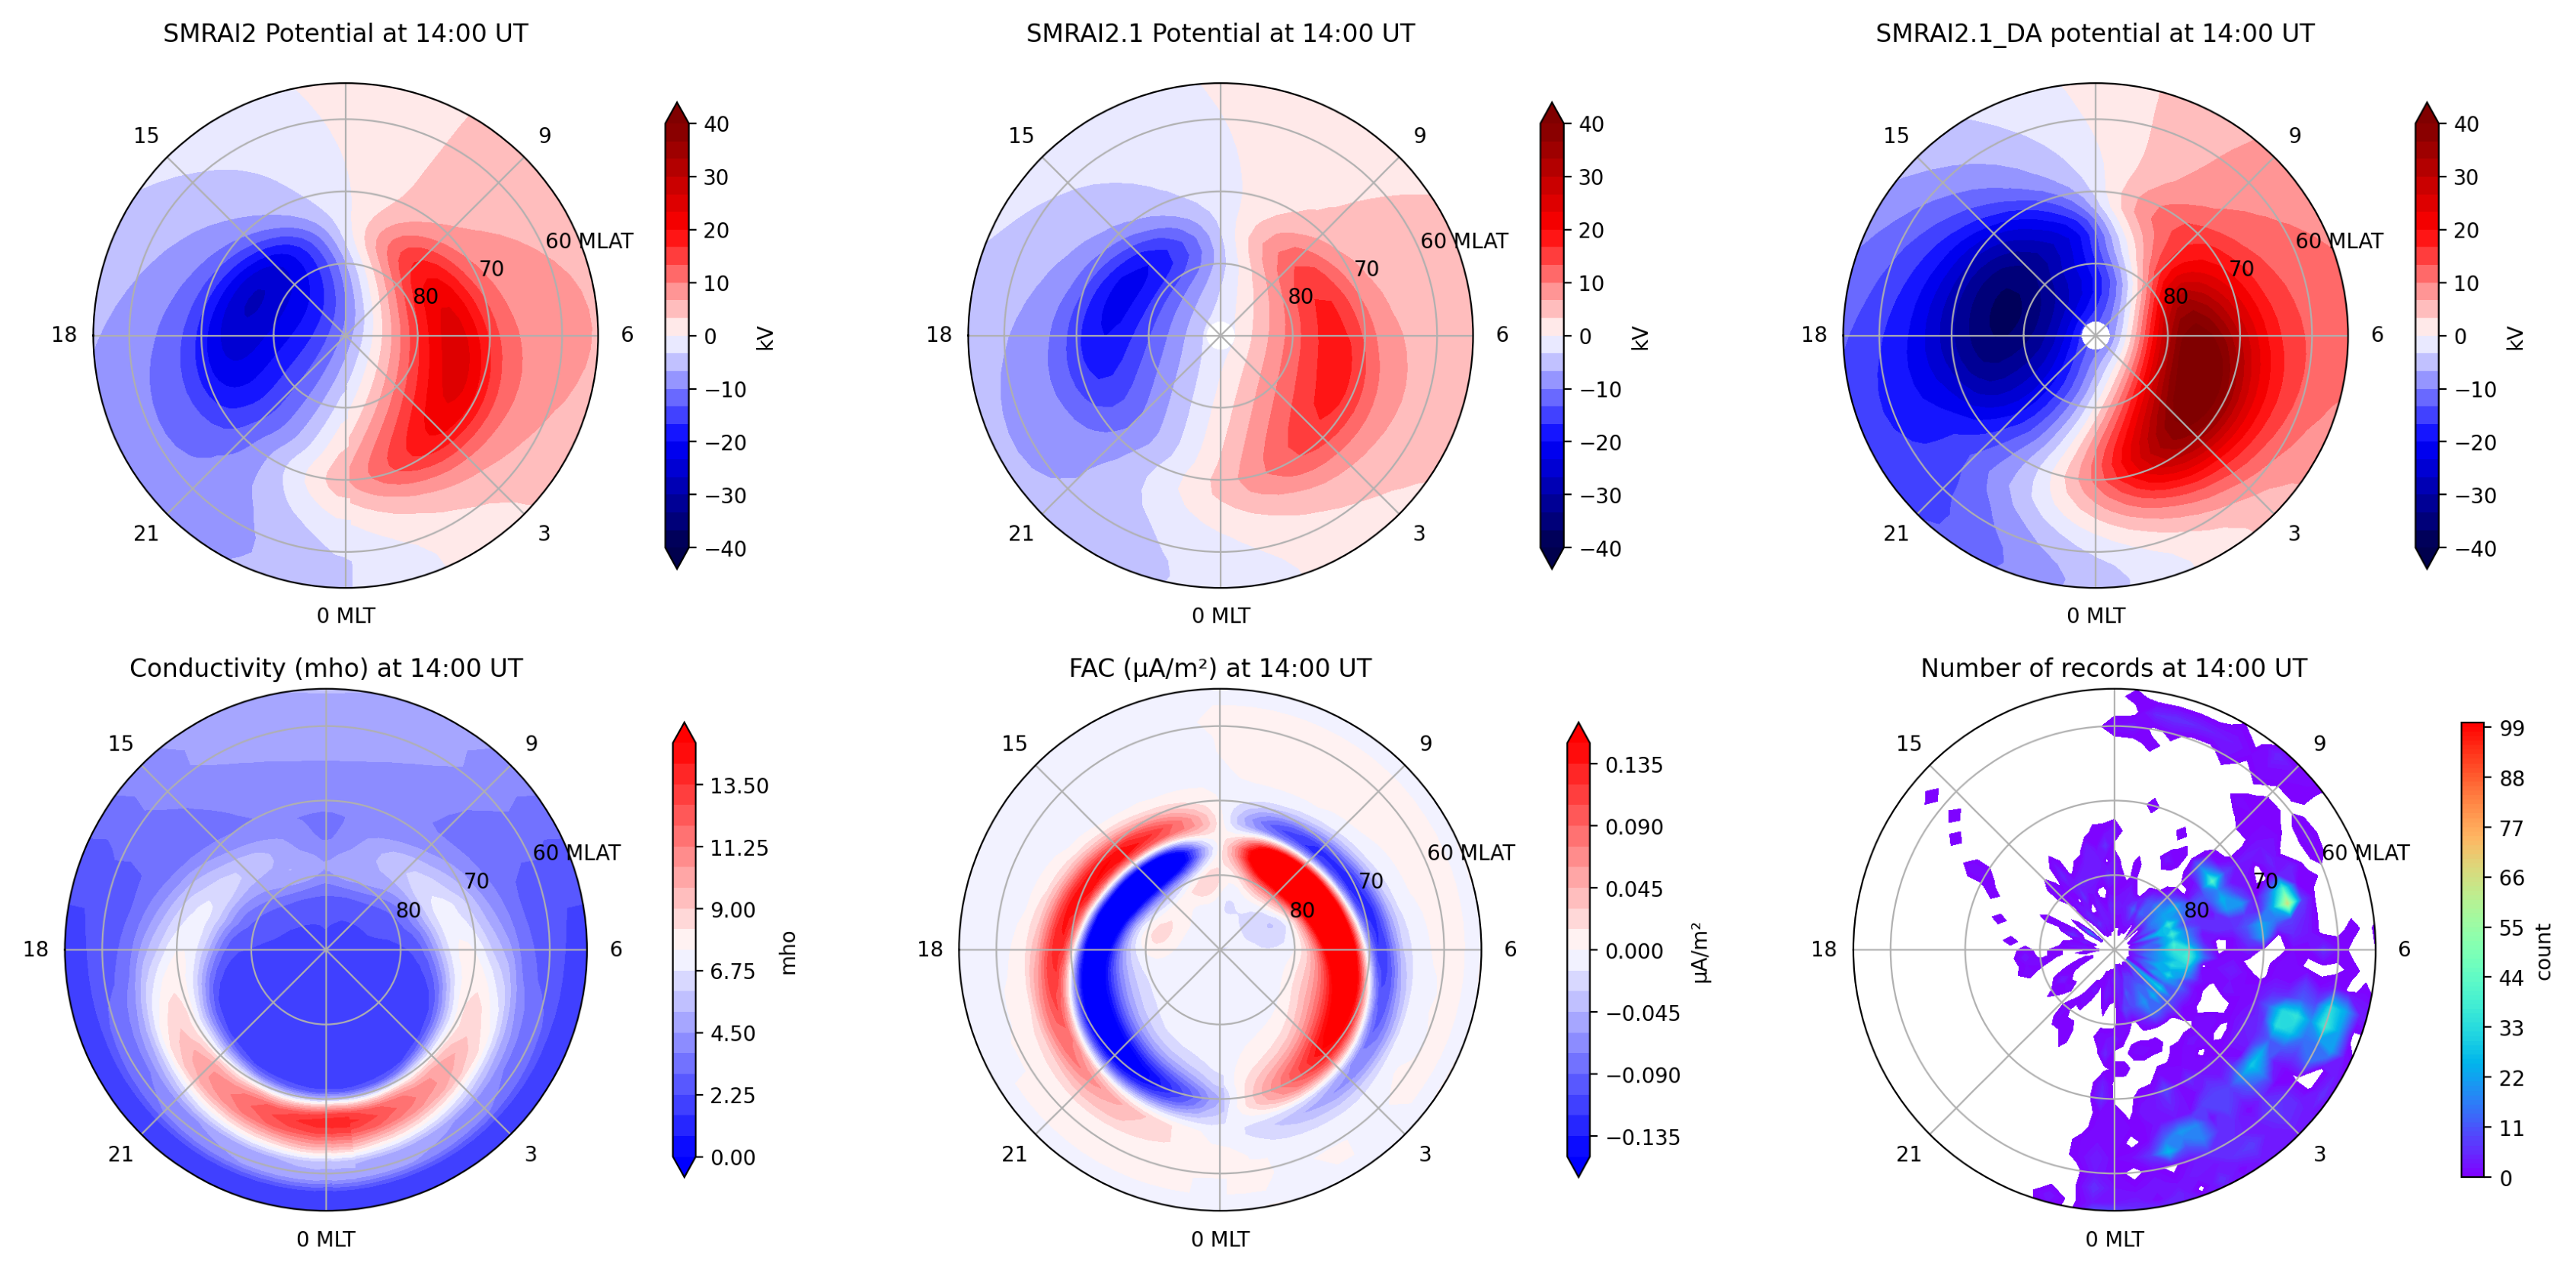

In [24]:
# Merge saved PNG files: pot_{hhmm}UT.png and fcp_{hhmm}.png

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Choose the time interval
time_idx = idx  # Change this to the time index you want

# Calculate hour, minute, and hhmm from time_idx
hour = (time_idx * 5) // 60
minute = (time_idx * 5) % 60
hhmm = f"{hour:02d}{minute:02d}"

# File paths
pot_file = f'pot_{hhmm}UT.png'
fcp_file = f'fcp_{hhmm}.png'

# Check if files exist
if not os.path.exists(pot_file):
    print(f"Error: {pot_file} not found!")
elif not os.path.exists(fcp_file):
    print(f"Error: {fcp_file} not found!")
else:
    # Load the images
    pot_img = Image.open(pot_file)
    fcp_img = Image.open(fcp_file)
    
    # Get dimensions
    pot_width, pot_height = pot_img.size
    fcp_width, fcp_height = fcp_img.size
    
    # Create a new image with height = pot_height + fcp_height, width = max of both
    merged_width = max(pot_width, fcp_width)
    merged_height = pot_height + fcp_height
    
    # Create merged image (white background)
    merged_img = Image.new('RGB', (merged_width, merged_height), 'white')
    
    # Paste pot image at the top (centered if widths differ)
    pot_x_offset = (merged_width - pot_width) // 2
    merged_img.paste(pot_img, (pot_x_offset, 0))
    
    # Paste fcp image at the bottom (centered if widths differ)
    fcp_x_offset = (merged_width - fcp_width) // 2
    merged_img.paste(fcp_img, (fcp_x_offset, pot_height))
    
    # Save the merged image
    output_file = f'pot_con_fac_sd_{hhmm}.png'
    merged_img.save(output_file, dpi=(200, 200))
    print(f"Merged plot saved as: {output_file}")
    
    # Display the merged image
    plt.figure(figsize=(merged_width/100, merged_height/100), dpi=100)
    plt.imshow(merged_img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
